In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

In [86]:
# Загрузка данных
df = pd.read_csv('homework_m3.csv', index_col=0)
users = pd.read_csv('homework_m3_users.csv', index_col=0)

# Преобразование дат
df['event_date'] = pd.to_datetime(df['event_date'])

print("Размер df:", df.shape)
print("Размер users:", users.shape)
print("Первые 5 строк df:")
print(df.head())
print("Первые 5 строк users:")
print(users.head())

Размер df: (423721, 7)
Размер users: (4969, 3)
Первые 5 строк df:
   event_id                               user_id       event_datetime  \
0         0  6ef47377-99ce-410d-ad94-f8a6765f0ce7  2022-04-01 00:00:56   
1       233  6ef47377-99ce-410d-ad94-f8a6765f0ce7  2022-04-01 03:34:11   
2      4877  6ef47377-99ce-410d-ad94-f8a6765f0ce7  2022-04-04 03:01:55   
3      5164  6ef47377-99ce-410d-ad94-f8a6765f0ce7  2022-04-04 07:20:09   
4     14092  6ef47377-99ce-410d-ad94-f8a6765f0ce7  2022-04-10 04:25:23   

  event_date event_month event_name  amount  
0 2022-04-01  2022-04-01      visit       0  
1 2022-04-01  2022-04-01      visit       0  
2 2022-04-04  2022-04-01      visit       0  
3 2022-04-04  2022-04-01      visit       0  
4 2022-04-10  2022-04-01      visit       0  
Первые 5 строк users:
                                user_id  gender  os_name
0  001dad40-62b0-442d-849c-60318f09c862  female  android
1  0026c978-47cd-4c64-b9aa-75cf6973761b  female  android
2  0034cc76-3307-490

### Анализ воронки

In [11]:
df.head()

,event_id,user_id,event_datetime,event_date,event_month,event_name,amount
0,0,6ef47377-99ce-410d-ad94-f8a6765f0ce7,2022-04-01 00:00:56,2022-04-01,2022-04-01,visit,0
1,233,6ef47377-99ce-410d-ad94-f8a6765f0ce7,2022-04-01 03:34:11,2022-04-01,2022-04-01,visit,0
2,4877,6ef47377-99ce-410d-ad94-f8a6765f0ce7,2022-04-04 03:01:55,2022-04-04,2022-04-01,visit,0
3,5164,6ef47377-99ce-410d-ad94-f8a6765f0ce7,2022-04-04 07:20:09,2022-04-04,2022-04-01,visit,0
4,14092,6ef47377-99ce-410d-ad94-f8a6765f0ce7,2022-04-10 04:25:23,2022-04-10,2022-04-01,visit,0


In [88]:
# Количество уникальных пользователей на каждом шаге воронки
funnel = df.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
print("Количество пользователей по шагам:")
print(funnel)

Количество пользователей по шагам:
event_name
visit          4969
choose_item    4286
purchase       1374
Name: user_id, dtype: int64


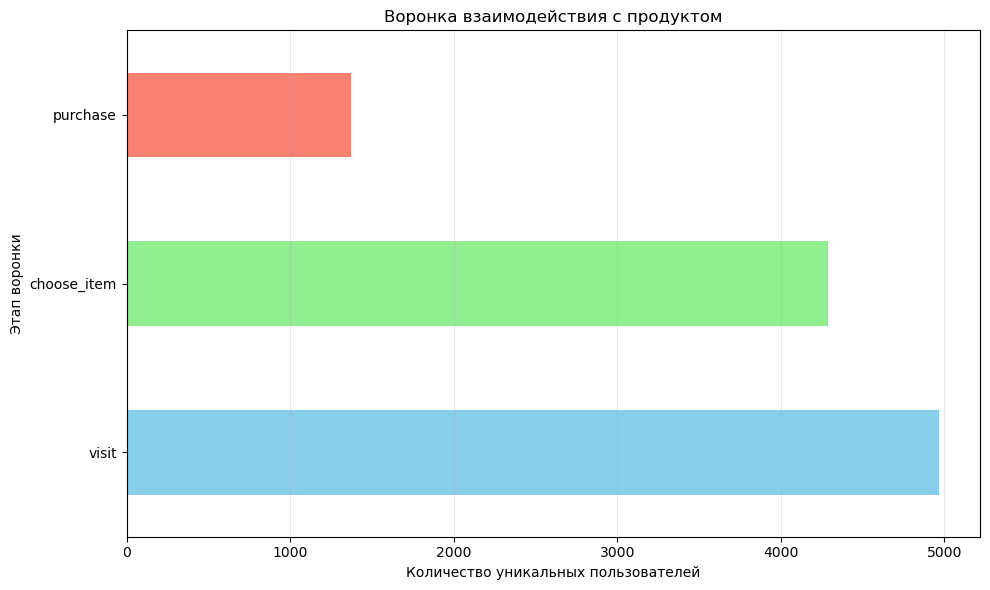

In [90]:
# Построение графика
plt.figure(figsize=(10, 6))
funnel.plot(kind='barh', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Воронка взаимодействия с продуктом')
plt.xlabel('Количество уникальных пользователей')
plt.ylabel('Этап воронки')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [92]:
# Расчет конверсий
conversion = (funnel / funnel.shift(1) * 100).round(2)
conversion.iloc[0] = 100  # Первый шаг всегда 100%
print("Конверсия относительно предыдущего шага (%):")
print(conversion)

Конверсия относительно предыдущего шага (%):
event_name
visit          100.00
choose_item     86.25
purchase        32.06
Name: user_id, dtype: float64


In [94]:
# Дополнительное задание: конверсии в динамике
print("\nДополнительное задание: конверсии в динамике")
df['month'] = df['event_date'].dt.to_period('M')
monthly_funnel = df.pivot_table(
    index='month', 
    columns='event_name', 
    values='user_id', 
    aggfunc='nunique')

# Переупорядочиваем колонки в правильной последовательности воронки
monthly_funnel = monthly_funnel[['visit', 'choose_item', 'purchase']]

# Расчет конверсий по месяцам
monthly_conversion = monthly_funnel.copy()
monthly_conversion['visit_to_choose'] = (monthly_funnel['choose_item'] / monthly_funnel['visit'] * 100).round(2)
monthly_conversion['choose_to_purchase'] = (monthly_funnel['purchase'] / monthly_funnel['choose_item'] * 100).round(2)
monthly_conversion['overall'] = (monthly_funnel['purchase'] / monthly_funnel['visit'] * 100).round(2)

print("Конверсии по месяцам:")
print(monthly_conversion[['visit_to_choose', 'choose_to_purchase', 'overall']])


Дополнительное задание: конверсии в динамике
Конверсии по месяцам:
event_name  visit_to_choose  choose_to_purchase  overall
month                                                   
2022-04               30.30               12.98     3.93
2022-05               30.62               11.04     3.38
2022-06               29.78               12.38     3.69
2022-07               30.77               12.71     3.91
2022-08               32.12               11.97     3.84
2022-09               30.37               14.38     4.37
2022-10               32.47               13.48     4.38
2022-11               30.64               12.34     3.78
2022-12               30.65               13.80     4.23


### Сегментация

In [96]:
# Объединение таблиц
df = df.merge(users, on='user_id', how='left')
print("Размер объединенной таблицы:", df.shape)

Размер объединенной таблицы: (423721, 10)


In [98]:
# Воронка для женщин
df_female = df[df['gender'] == 'female']
funnel_female = df_female.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

# Воронка для мужчин
df_male = df[df['gender'] == 'male']
funnel_male = df_male.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

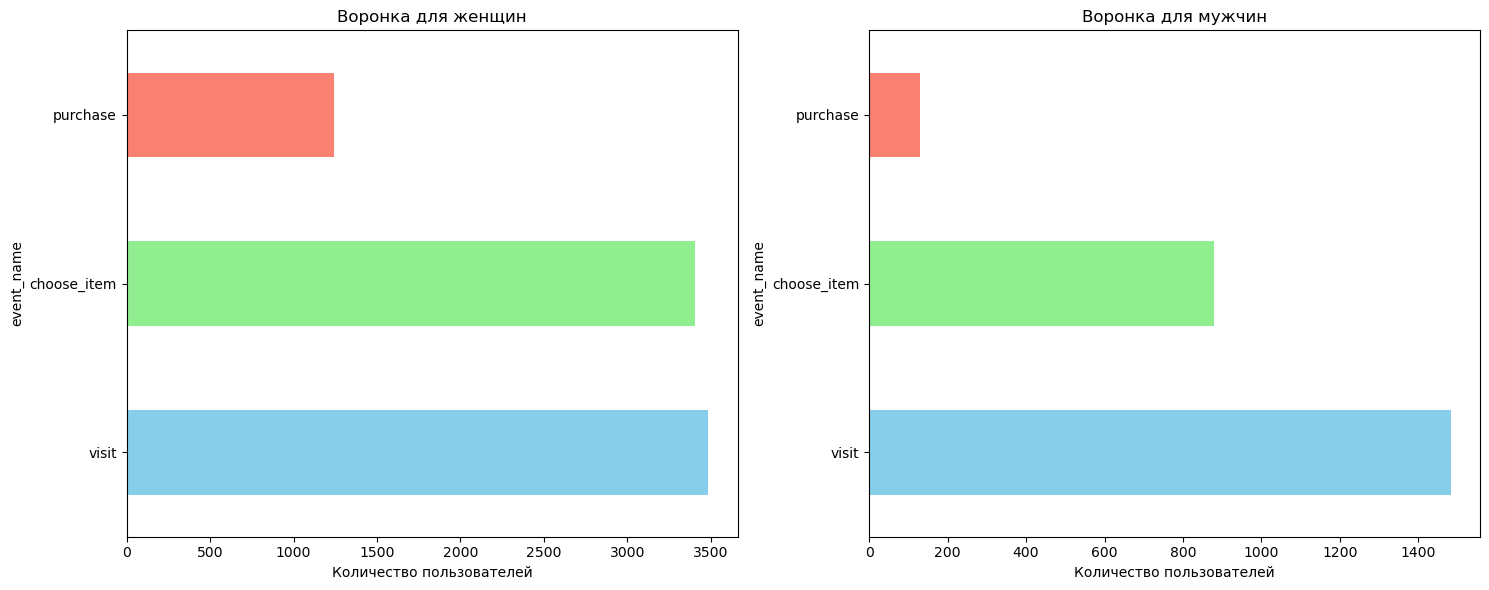

In [100]:
# Построение графиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

funnel_female.plot(kind='barh', ax=ax1, color=['skyblue', 'lightgreen', 'salmon'])
ax1.set_title('Воронка для женщин')
ax1.set_xlabel('Количество пользователей')

funnel_male.plot(kind='barh', ax=ax2, color=['skyblue', 'lightgreen', 'salmon'])
ax2.set_title('Воронка для мужчин')
ax2.set_xlabel('Количество пользователей')

plt.tight_layout()
plt.show()

In [102]:
# Конверсии по полу
conversion_female = (funnel_female / funnel_female.shift(1) * 100).round(2)
conversion_female.iloc[0] = 100

conversion_male = (funnel_male / funnel_male.shift(1) * 100).round(2)
conversion_male.iloc[0] = 100

print("Конверсии для женщин (%):")
print(conversion_female)
print("Конверсии для мужчин (%):")
print(conversion_male)

Конверсии для женщин (%):
event_name
visit          100.00
choose_item     97.76
purchase        36.53
Name: user_id, dtype: float64
Конверсии для мужчин (%):
event_name
visit          100.00
choose_item     59.20
purchase        14.69
Name: user_id, dtype: float64


In [104]:
# Воронка по платформам (используем os_name)
print("Уникальные значения в os_name:", df['os_name'].unique())

df_android = df[df['os_name'] == 'android']
df_apple = df[df['os_name'] == 'apple']

print(f"Количество записей Android: {len(df_android)}")
print(f"Количество записей Apple: {len(df_apple)}")

funnel_android = df_android.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
funnel_apple = df_apple.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

print("Воронка для Android:")
print(funnel_android)
print("Воронка для Apple:")
print(funnel_apple)

Уникальные значения в os_name: ['android' 'apple']
Количество записей Android: 327589
Количество записей Apple: 96132
Воронка для Android:
event_name
visit          3895
choose_item    3365
purchase       1124
Name: user_id, dtype: int64
Воронка для Apple:
event_name
visit          1074
choose_item     921
purchase        250
Name: user_id, dtype: int64


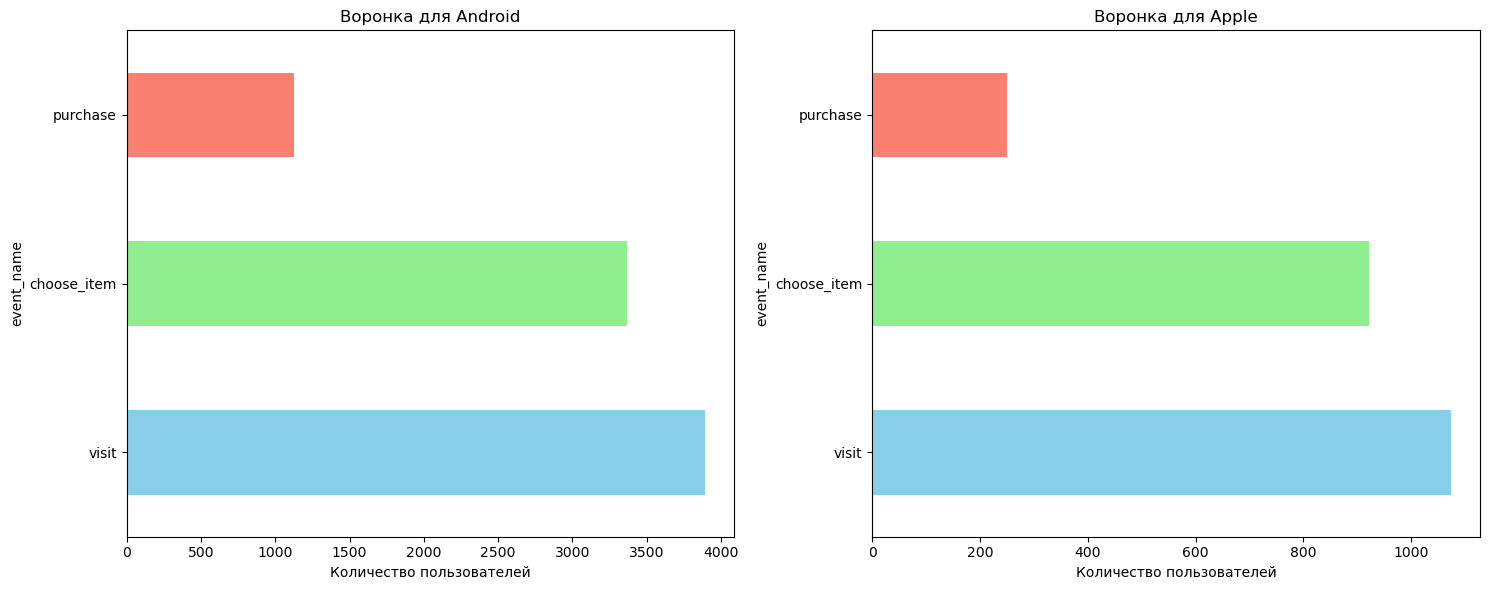

In [106]:
# Проверяем, есть ли данные для построения графиков
if not funnel_android.empty and not funnel_apple.empty:
    # Оба графика есть
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    funnel_android.plot(kind='barh', ax=ax1, color=['skyblue', 'lightgreen', 'salmon'])
    ax1.set_title('Воронка для Android')
    ax1.set_xlabel('Количество пользователей')
    
    funnel_apple.plot(kind='barh', ax=ax2, color=['skyblue', 'lightgreen', 'salmon'])
    ax2.set_title('Воронка для Apple')
    ax2.set_xlabel('Количество пользователей')
    
    plt.tight_layout()
    plt.show()
    
elif not funnel_android.empty:
    # Только Android есть данные
    plt.figure(figsize=(8, 6))
    funnel_android.plot(kind='barh', color=['skyblue', 'lightgreen', 'salmon'])
    plt.title('Воронка для Android')
    plt.xlabel('Количество пользователей')
    plt.tight_layout()
    plt.show()
    
elif not funnel_apple.empty:
    # Только Apple есть данные
    plt.figure(figsize=(8, 6))
    funnel_apple.plot(kind='barh', color=['skyblue', 'lightgreen', 'salmon'])
    plt.title('Воронка для Apple')
    plt.xlabel('Количество пользователей')
    plt.tight_layout()
    plt.show()
    
else:
    print("Нет данных ни для Android, ни для Apple")

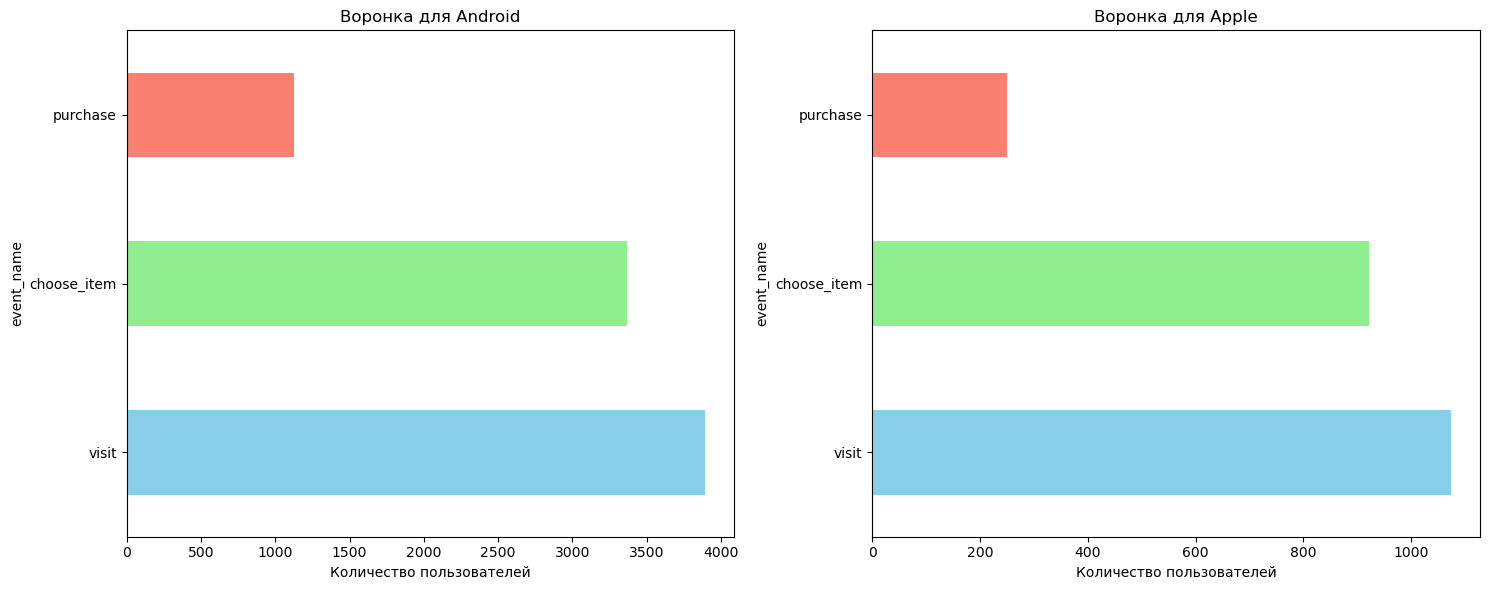


Конверсии для Android (%):
event_name
visit          100.00
choose_item     86.39
purchase        33.40
Name: user_id, dtype: float64

Конверсии для Apple (%):
event_name
visit          100.00
choose_item     85.75
purchase        27.14
Name: user_id, dtype: float64


In [108]:
# Проверяем, есть ли данные для построения графиков
if not funnel_android.empty and not funnel_apple.empty:
    # Оба графика есть
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    funnel_android.plot(kind='barh', ax=ax1, color=['skyblue', 'lightgreen', 'salmon'])
    ax1.set_title('Воронка для Android')
    ax1.set_xlabel('Количество пользователей')
    
    funnel_apple.plot(kind='barh', ax=ax2, color=['skyblue', 'lightgreen', 'salmon'])
    ax2.set_title('Воронка для Apple')
    ax2.set_xlabel('Количество пользователей')
    
    plt.tight_layout()
    plt.show()
    
elif not funnel_android.empty:
    # Только Android есть данные
    plt.figure(figsize=(8, 6))
    funnel_android.plot(kind='barh', color=['skyblue', 'lightgreen', 'salmon'])
    plt.title('Воронка для Android')
    plt.xlabel('Количество пользователей')
    plt.tight_layout()
    plt.show()
    
elif not funnel_apple.empty:
    # Только Apple есть данные
    plt.figure(figsize=(8, 6))
    funnel_apple.plot(kind='barh', color=['skyblue', 'lightgreen', 'salmon'])
    plt.title('Воронка для Apple')
    plt.xlabel('Количество пользователей')
    plt.tight_layout()
    plt.show()
    
else:
    print("Нет данных ни для Android, ни для Apple")

# Расчет конверсий по платформам
if not funnel_android.empty:
    conversion_android = (funnel_android / funnel_android.shift(1) * 100).round(2)
    conversion_android.iloc[0] = 100
    print("\nКонверсии для Android (%):")
    print(conversion_android)

if not funnel_apple.empty:
    conversion_apple = (funnel_apple / funnel_apple.shift(1) * 100).round(2)
    conversion_apple.iloc[0] = 100
    print("\nКонверсии для Apple (%):")
    print(conversion_apple)

In [110]:
# Дополнительное задание: ARPPU по полу
print("Дополнительное задание: ARPPU по полу")
purchase_data = df[df['event_name'] == 'purchase']
arppu_gender = purchase_data.groupby('gender')['amount'].mean().round(2)
print("ARPPU по полу:")
print(arppu_gender)

Дополнительное задание: ARPPU по полу
ARPPU по полу:
gender
female    1267.0
male      1267.0
Name: amount, dtype: float64


In [112]:
# MAU по платформам
print("MAU по платформам:")
mau_platform = df[df['event_name'] == 'visit'].groupby(['os_name', df['event_date'].dt.to_period('M')])['user_id'].nunique()
print(mau_platform.groupby('os_name').mean().round(2))

MAU по платформам:
os_name
android    3714.89
apple      1024.33
Name: user_id, dtype: float64


### RFM

In [114]:
# подготовка: создайте датафрейм, содержащий только события покупки
df_rfm = df[df['event_name'] == 'purchase'].copy()

In [140]:
# Определяем дату анализа (последняя дата + 1 день)
today = df_rfm['event_date'].max() + pd.Timedelta(days=1)
print(f"Дата RFM анализа: {today}")

Дата RFM анализа: 2023-01-01 00:00:00


In [142]:
# создайте таблицу с метриками: сгруппируйте по пользователям и посчитайте метрики Recency, Frequency и MonetaryValue
rfm = df_rfm.groupby('user_id').agg({
    'event_date': lambda x: (today - x.max()).days, 
    'event_id': lambda x: len(x), 
    'amount': lambda x: x.sum()
}).reset_index()

In [144]:
# Переименовываем колонки
rfm.rename(columns={
    'event_date': 'Recency', 
    'event_id': 'Frequency', 
    'amount': 'MonetaryValue'
}, inplace=True)

print("RFM таблица (первые 5 строк):")
print(rfm.head())

print("Описательная статистика RFM метрик:")
print(rfm[['Recency', 'Frequency', 'MonetaryValue']].describe())

RFM таблица (первые 5 строк):
                                user_id  Recency  Frequency  MonetaryValue
0  001dad40-62b0-442d-849c-60318f09c862      237          1           1267
1  0045f6a3-2a4e-4349-8b32-cb604df95c4d      137          2           2534
2  0055a93e-d48a-4254-a0c4-463b6622a97d      144          1           1267
3  00e8a0a8-7bdf-461d-a71b-a113013ef1e3      164          1           1267
4  00eaf572-91bb-4ebb-ad6b-d0b3cc435162       36          1           1267
Описательная статистика RFM метрик:
           Recency    Frequency  MonetaryValue
count  1374.000000  1374.000000    1374.000000
mean    124.029840     1.261281    1598.042940
std      78.715534     0.525532     665.848758
min       1.000000     1.000000    1267.000000
25%      56.250000     1.000000    1267.000000
50%     114.000000     1.000000    1267.000000
75%     189.000000     1.000000    1267.000000
max     275.000000     4.000000    5068.000000


In [146]:
# Проверяем уникальные значения Frequency
print(f"Уникальные значения Frequency: {sorted(rfm['Frequency'].unique())}")
print(f"Количество уникальных значений Frequency: {rfm['Frequency'].nunique()}")

Уникальные значения Frequency: [1, 2, 3, 4]
Количество уникальных значений Frequency: 4


In [148]:
# Функция для безопасного создания категорий
def create_rfm_categories(data, column_name, labels):
    """
    Создает категории для RFM анализа с обработкой дубликатов
    """
    unique_values = data[column_name].nunique()
    
    if unique_values <= len(labels):
        # Если уникальных значений меньше или равно количеству категорий
        print(f"Для {column_name} только {unique_values} уникальных значений")
        
        # Создаем маппинг значений на категории
        sorted_values = sorted(data[column_name].unique())
        value_to_category = {}
        
        for i, value in enumerate(sorted_values):
            # Распределяем значения по категориям равномерно
            category_index = min(i, len(labels) - 1)
            value_to_category[value] = labels[category_index]
        
        return data[column_name].map(value_to_category)
    
    else:
        # Пытаемся использовать qcut с обработкой дубликатов
        try:
            return pd.qcut(data[column_name], q=len(labels), labels=labels, duplicates='drop')
        except ValueError:
            # Если qcut не работает, используем равномерные бины
            print(f"Используем равномерные бины для {column_name}")
            min_val = data[column_name].min()
            max_val = data[column_name].max()
            bins = np.linspace(min_val, max_val, len(labels) + 1)
            return pd.cut(data[column_name], bins=bins, labels=labels, include_lowest=True)

In [156]:
# Создаем категории
rfm['Recency_q'] = create_rfm_categories(rfm, 'Recency', [3, 2, 1])
rfm['Frequency_q'] = create_rfm_categories(rfm, 'Frequency', [1, 2, 3])
rfm['MonetaryValue_q'] = create_rfm_categories(rfm, 'MonetaryValue', [1, 2, 3])

# Проверяем результат
print(f"Распределение Recency_q:")
print(rfm['Recency_q'].value_counts().sort_index())
print(f"Распределение Frequency_q:")
print(rfm['Frequency_q'].value_counts().sort_index())
print(f"Распределение MonetaryValue_q:")
print(rfm['MonetaryValue_q'].value_counts().sort_index())

Используем равномерные бины для Frequency
Используем равномерные бины для MonetaryValue
Распределение Recency_q:
Recency_q
3    462
2    457
1    455
Name: count, dtype: int64
Распределение Frequency_q:
Frequency_q
1    1329
2      39
3       6
Name: count, dtype: int64
Распределение MonetaryValue_q:
MonetaryValue_q
1    1329
2      39
3       6
Name: count, dtype: int64


In [158]:
# Анализ сегментов
try:
    segment_stats = rfm.groupby(['Recency_q', 'Frequency_q', 'MonetaryValue_q']).agg({
        'user_id': 'count',
        'Recency': 'mean',
        'Frequency': 'mean',
        'MonetaryValue': 'mean'
    }).round(2)
    
    print("\nСтатистика по RFM сегментам:")
    print(segment_stats)
    
except Exception as e:
    print(f"Ошибка при группировке по трем категориям: {e}")
    print("Используем анализ по отдельным метрикам")


Статистика по RFM сегментам:
                                       user_id  Recency  Frequency  \
Recency_q Frequency_q MonetaryValue_q                                
3         1           1                    429    38.03       1.32   
                      2                      0      NaN        NaN   
                      3                      0      NaN        NaN   
          2           1                      0      NaN        NaN   
                      2                     27    35.22       3.00   
                      3                      0      NaN        NaN   
          3           1                      0      NaN        NaN   
                      2                      0      NaN        NaN   
                      3                      6    24.17       4.00   
2         1           1                    446   117.61       1.21   
                      2                      0      NaN        NaN   
                      3                      0      NaN     

In [160]:
# Анализ по отдельным RFM метрикам
print("\nАнализ по отдельным RFM метрикам:")

# Анализ Recency
recency_stats = rfm.groupby('Recency_q').agg({
    'user_id': 'count',
    'Recency': ['mean', 'min', 'max']
}).round(2)
print("Recency анализ:")
print(recency_stats)


Анализ по отдельным RFM метрикам:
Recency анализ:
          user_id Recency          
            count    mean  min  max
Recency_q                          
3             462   37.69    1   77
2             457  117.37   78  164
1             455  218.39  165  275


In [162]:
# Анализ Frequency
frequency_stats = rfm.groupby('Frequency_q').agg({
    'user_id': 'count',
    'Frequency': ['mean', 'min', 'max']
}).round(2)
print("\nFrequency анализ:")
print(frequency_stats)


Frequency анализ:
            user_id Frequency        
              count      mean min max
Frequency_q                          
1              1329       1.2   1   2
2                39       3.0   3   3
3                 6       4.0   4   4


In [164]:
# Анализ MonetaryValue
monetary_stats = rfm.groupby('MonetaryValue_q').agg({
    'user_id': 'count',
    'MonetaryValue': ['mean', 'min', 'max']
}).round(2)
print("\nMonetaryValue анализ:")
print(monetary_stats)


MonetaryValue анализ:
                user_id MonetaryValue            
                  count          mean   min   max
MonetaryValue_q                                  
1                  1329       1517.73  1267  2534
2                    39       3801.00  3801  3801
3                     6       5068.00  5068  5068


In [166]:
# ARPPU по сегментам
try:
    arppu_segments = rfm.groupby(['Recency_q', 'Frequency_q', 'MonetaryValue_q'])['MonetaryValue'].mean().round(2)
    print("ARPPU по сегментам:")
    print(arppu_segments)
except:
    print("Не удалось рассчитать ARPPU по трем категориям")

ARPPU по сегментам:
Recency_q  Frequency_q  MonetaryValue_q
3          1            1                  1668.66
                        2                      NaN
                        3                      NaN
           2            1                      NaN
                        2                  3801.00
                        3                      NaN
           3            1                      NaN
                        2                      NaN
                        3                  5068.00
2          1            1                  1531.20
                        2                      NaN
                        3                      NaN
           2            1                      NaN
                        2                  3801.00
                        3                      NaN
           3            1                      NaN
                        2                      NaN
                        3                      NaN
1          1          

In [168]:
# Простой RFM score
rfm['RFM_Score'] = rfm['Recency_q'].astype(int) + rfm['Frequency_q'].astype(int) + rfm['MonetaryValue_q'].astype(int)

print("Распределение RFM Score:")
print(rfm['RFM_Score'].value_counts().sort_index())

Распределение RFM Score:
RFM_Score
3    454
4    446
5    430
6     11
7     27
9      6
Name: count, dtype: int64


In [172]:
# Анализ лучших клиентов (топ 20% по RFM score)
rfm_quantile = rfm['RFM_Score'].quantile(0.8)
best_customers = rfm[rfm['RFM_Score'] >= rfm_quantile]
print(f"Лучшие клиенты (топ 20%): {len(best_customers)} пользователей")
print(f"Средний RFM Score лучших клиентов: {best_customers['RFM_Score'].mean():.2f}")

Лучшие клиенты (топ 20%): 474 пользователей
Средний RFM Score лучших клиентов: 5.19


In [174]:
# Добавляем информацию о платформе в RFM анализ
rfm_with_os = rfm.merge(users[['user_id', 'os_name']], on='user_id', how='left')

# Анализ RFM по платформам
rfm_os_stats = rfm_with_os.groupby('os_name').agg({
    'Recency': 'mean',
    'Frequency': 'mean', 
    'MonetaryValue': 'mean',
    'user_id': 'count',
    'RFM_Score': 'mean'
}).round(2)

print("RFM метрики по платформам:")
print(rfm_os_stats)

RFM метрики по платформам:
         Recency  Frequency  MonetaryValue  user_id  RFM_Score
os_name                                                       
android   133.90       1.06        1344.78     1124       3.92
apple      79.67       2.16        2736.72      250       4.78


### Когортный анализ

In [177]:
# найдите для каждого пользователя первый месяц взаимодействия с продуктом
first_month = df.groupby('user_id')['event_date'].min().dt.to_period('M').reset_index()
first_month.rename(columns={'event_date': 'first_event_month'}, inplace=True)

In [179]:
# объедините таблицу с первым месяцем и таблицу с событиями
df = df.merge(first_month, on='user_id', how='left')

In [181]:
# посчитайте порядковый номер месяца как разность между первым месяцем и месяцем совершения действия
# используйте метод .dt.month, чтобы получить номер месяца 
df['event_month'] = df['event_date'].dt.to_period('M')
df['lt_month'] = (df['event_month'] - df['first_event_month']).apply(lambda x: x.n)

In [185]:
# создайте сводную таблицу с помощью метода .pivot_table. Строки - первый месяц. Столбцы - порядковый номер месяца
cohort_pivot = df.pivot_table(
    index='first_event_month',
    columns='lt_month',
    values='user_id',
    aggfunc='nunique',
    fill_value=0)

print("Когортный анализ (количество уникальных пользователей):")
print(cohort_pivot)

Когортный анализ (количество уникальных пользователей):
lt_month              0     1     2     3     4     5     6     7     8
first_event_month                                                      
2022-04            4729  4604  4605  4599  4613  4588  4615  4595  4612
2022-05             128    85    79    80    92    91    91    85     0
2022-06              54    25    25    29    29    27    32     0     0
2022-07              29     8    15    12     8    14     0     0     0
2022-08               9     5     2     3     3     0     0     0     0
2022-09              10     1     4     2     0     0     0     0     0
2022-10               2     2     0     0     0     0     0     0     0
2022-11               6     4     0     0     0     0     0     0     0
2022-12               2     0     0     0     0     0     0     0     0


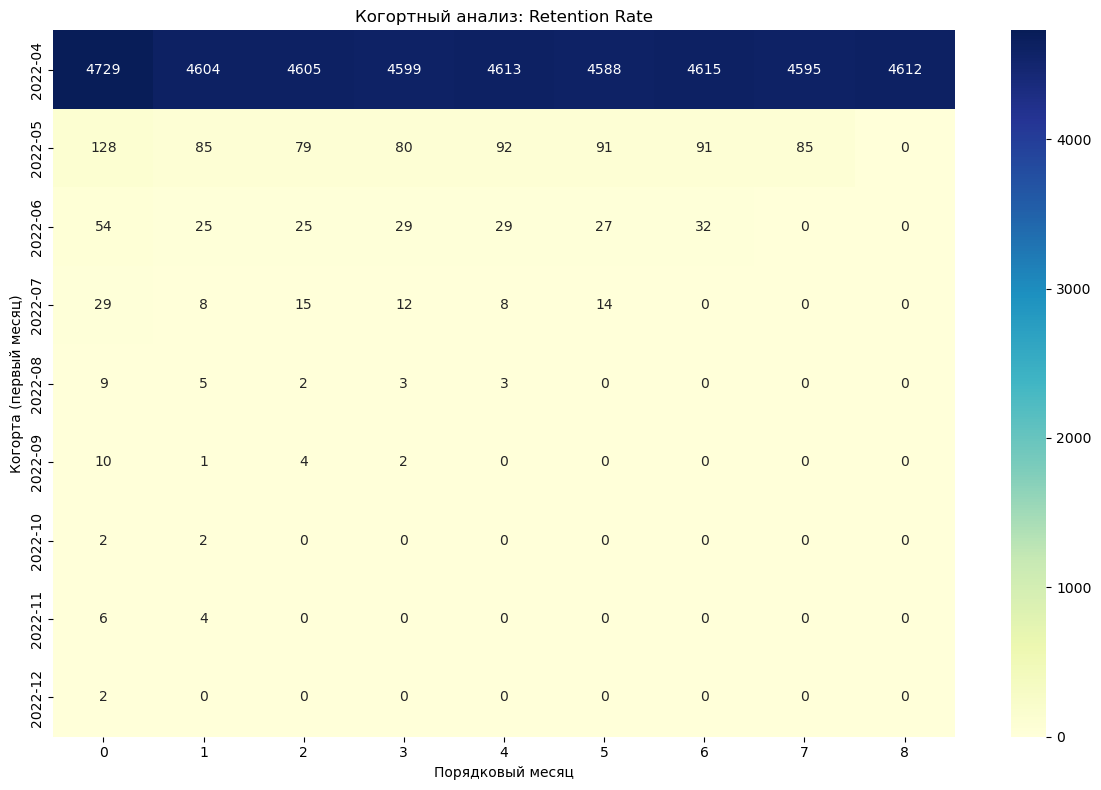

In [195]:
# Визуализация когортного анализа
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Когортный анализ: Retention Rate')
plt.xlabel('Порядковый месяц')
plt.ylabel('Когорта (первый месяц)')
plt.tight_layout()
plt.show()

In [199]:
# Дополнительное задание: когортный анализ по платформам
print("Дополнительное задание: когортный анализ по платформам")

# Для Android
cohort_android = df[df['os_name'] == 'android'].pivot_table(
    index='first_event_month',
    columns='lt_month',
    values='user_id',
    aggfunc='nunique',
    fill_value=0)

# Для Apple
cohort_apple = df[df['os_name'] == 'apple'].pivot_table(
    index='first_event_month',
    columns='lt_month',
    values='user_id',
    aggfunc='nunique',
    fill_value=0)

print("Когортный анализ для Android:")
print(cohort_android)
print("Когортный анализ для Apple:")
print(cohort_apple)

Дополнительное задание: когортный анализ по платформам
Когортный анализ для Android:
lt_month              0     1     2     3     4     5     6     7     8
first_event_month                                                      
2022-04            3708  3608  3614  3605  3618  3599  3622  3604  3619
2022-05              99    63    59    60    69    71    71    64     0
2022-06              40    21    21    23    20    19    24     0     0
2022-07              22     6    11    10     4    11     0     0     0
2022-08               9     5     2     3     3     0     0     0     0
2022-09               8     1     2     2     0     0     0     0     0
2022-10               1     1     0     0     0     0     0     0     0
2022-11               6     4     0     0     0     0     0     0     0
2022-12               2     0     0     0     0     0     0     0     0
Когортный анализ для Apple:
lt_month              0    1    2    3    4    5    6    7    8
first_event_month              

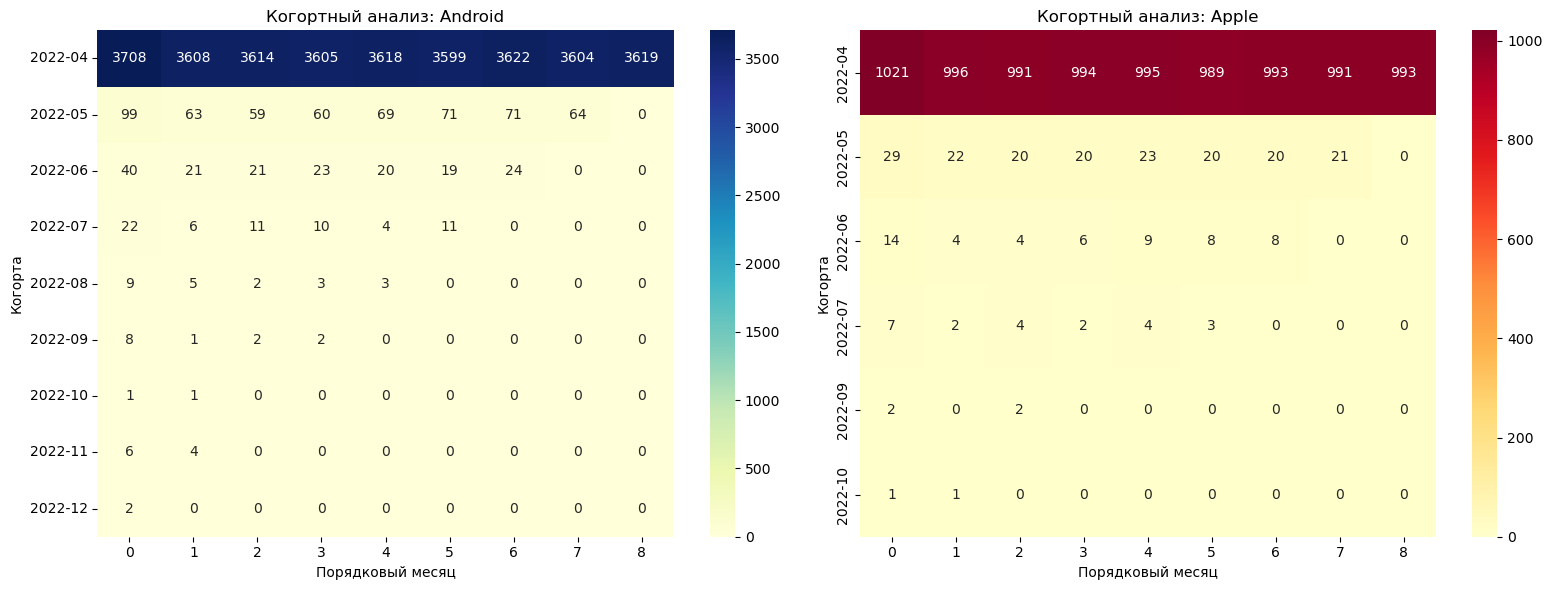

In [201]:
# Визуализация когортного анализа по платформам
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

if not cohort_android.empty:
    sns.heatmap(cohort_android, annot=True, fmt='.0f', cmap='YlGnBu', ax=ax1)
    ax1.set_title('Когортный анализ: Android')
    ax1.set_xlabel('Порядковый месяц')
    ax1.set_ylabel('Когорта')
else:
    ax1.text(0.5, 0.5, 'Нет данных для Android', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Когортный анализ: Android (нет данных)')

if not cohort_apple.empty:
    sns.heatmap(cohort_apple, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax2)
    ax2.set_title('Когортный анализ: Apple')
    ax2.set_xlabel('Порядковый месяц')
    ax2.set_ylabel('Когорта')
else:
    ax2.text(0.5, 0.5, 'Нет данных для Apple', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Когортный анализ: Apple (нет данных)')

plt.tight_layout()
plt.show()

Когортный анализ покупок:
lt_month             0    1    2    3    4    5    6    7    8
first_event_month                                             
2022-04            186  159  174  185  181  207  206  177  201
2022-05              1    0    0    1    0    2    1    0    0
2022-06              1    0    0    0    0    1    0    0    0


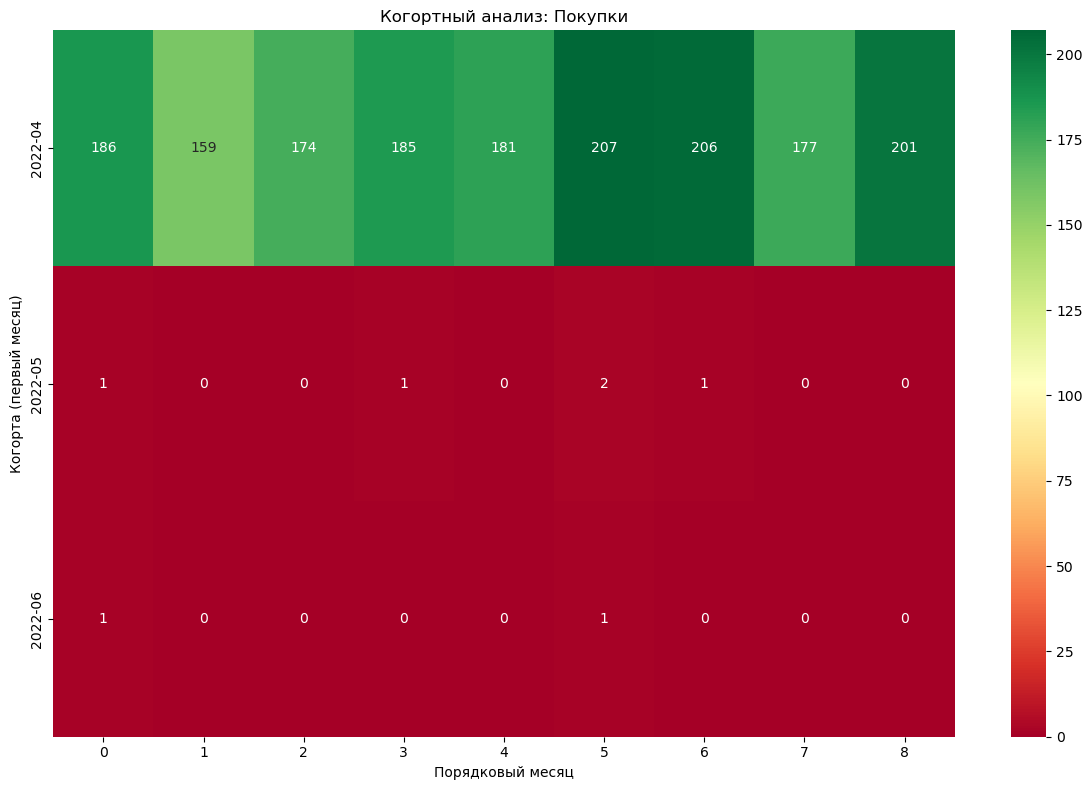

In [203]:
# Когортный анализ для покупок
cohort_purchase = df[df['event_name'] == 'purchase'].pivot_table(
    index='first_event_month',
    columns='lt_month',
    values='user_id',
    aggfunc='nunique',
    fill_value=0)

print("Когортный анализ покупок:")
print(cohort_purchase)

if not cohort_purchase.empty:
    plt.figure(figsize=(12, 8))
    sns.heatmap(cohort_purchase, annot=True, fmt='.0f', cmap='RdYlGn')
    plt.title('Когортный анализ: Покупки')
    plt.xlabel('Порядковый месяц')
    plt.ylabel('Когорта (первый месяц)')
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для когортного анализа покупок")

In [205]:
# Когортный анализ покупок по платформам
cohort_purchase_android = df[(df['os_name'] == 'android') & (df['event_name'] == 'purchase')].pivot_table(
    index='first_event_month',
    columns='lt_month',
    values='user_id',
    aggfunc='nunique',
    fill_value=0)

cohort_purchase_apple = df[(df['os_name'] == 'apple') & (df['event_name'] == 'purchase')].pivot_table(
    index='first_event_month',
    columns='lt_month',
    values='user_id',
    aggfunc='nunique',
    fill_value=0)

print("Когортный анализ покупок для Android:")
print(cohort_purchase_android)
print("Когортный анализ покупок для Apple:")
print(cohort_purchase_apple)

Когортный анализ покупок для Android:
lt_month             0    1    2    3    4    5    6    7    8
first_event_month                                             
2022-04            143  105  128  126  127  154  150  111  135
2022-05              1    0    0    1    0    2    1    0    0
2022-06              1    0    0    0    0    1    0    0    0
Когортный анализ покупок для Apple:
lt_month            0   1   2   3   4   5   6   7   8
first_event_month                                    
2022-04            43  54  46  59  54  53  56  66  66
